# **EDA🔍**

In [ ]:
# Importing Keras
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models

# Preprocessing layers
from keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

# Importing utils
import os
import numpy as np
import random
import plotly.subplots as sp
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from collections import defaultdict
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'

In [ ]:
def image_resizer(paths):
    """
    This function resizes the input images
    """
    with ThreadPoolExecutor() as executor:
        resized_images = list(executor.map(lambda x: Image.open(x).resize((350,250)), paths))
    return resized_images

def plot_images_list(images, title, subtitle):
    '''
    This functions helps to plot a matrix of images in a list
    '''
    fig = sp.make_subplots(rows=3, cols=3)
    images = image_resizer(images)

    traces = []
    for i in range(min(9, len(images))):
        img = go.Image(z=images[i])
        traces.append((img, i//3+1, i%3+1))

    fig.add_traces([trace[0] for trace in traces],
                  rows = [trace[1] for trace in traces],
                  cols = [trace[2] for trace in traces])

    fig.update_layout(
        title={'text': f'<b>{title}<br>  <i><sub>{subtitle}</sub></i></b>',
               'font': dict(size = 22)},
        height=800,
        width=800,
        margin=dict(t=110, l=80),
        plot_bgcolor=bg_color,paper_bgcolor=paper_color
        #template=template
    )
    fig.show()


In [ ]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)


GPU Found! Using GPU...


In [ ]:
# Loading training and testing directories
train_path = "/content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Training"
test_path = "/content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing"

In [ ]:
# Giving names to each directory
directories = {
    train_path: 'Training',
    test_path: 'Test'
    }

# Naming subfolders
subfolders = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)


* * * * * Number of files in each folder * * * * *


Training/glioma_tumor: 802

Training/meningioma_tumor: 707

Training/no_tumor: 246

Training/pituitary_tumor: 798

  Total: 2553
--------------------------------------------------------------------------------

Test/glioma_tumor: 84

Test/meningioma_tumor: 113

Test/no_tumor: 81

Test/pituitary_tumor: 36

  Total: 314
--------------------------------------------------------------------------------


# **PREPROCESSING🛠️**

In [ ]:
# Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    train_path,  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
    batch_size = 32,    # Number of processed samples before updating the model's weights
    image_size = (224, 224), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True, # Resize images without aspect ratio distortion
    color_mode = 'grayscale' # Imposta su 'grayscale' per immagini in scala di grigi
)

Found 2553 files belonging to 4 classes.


In [ ]:
# Creating a dataset for the Test data
test = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
    batch_size = 32,
    image_size = (224, 224),
    shuffle = True,
    seed = seed,
    validation_split = 0,
    crop_to_aspect_ratio = True,
    color_mode = 'grayscale'
)

Found 314 files belonging to 4 classes.


In [ ]:
print('\nTraining Dataset:', train)
print('\nTesting Dataset:', test)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [ ]:
# Converti il dataset di test in un iteratore Numpy
test_iterator = iter(test)

# Estrai le immagini e le etichette separatamente
test_images = []
test_labels = []

for images, labels in test_iterator:
    test_images.append(images)
    test_labels.append(labels)

# Concatena gli array Numpy
non_scaled_inputs_test = np.concatenate(test_images)
inputs_test = non_scaled_inputs_test / 255.0
targets_test = np.concatenate(test_labels)

# Shuffle degli elementi mantenendo l'associazione tra dati ed etichette
permutation = np.random.permutation(len(inputs_test))
inputs_test = inputs_test[permutation]
targets_test = targets_test[permutation]

In [ ]:
# Converti il dataset di train in un iteratore Numpy
train_iterator = iter(train)

# Estrai le immagini e le etichette separatamente
train_images = []
train_labels = []

for images, labels in train_iterator:
    train_images.append(images)
    train_labels.append(labels)

# Concatena gli array Numpy
non_scaled_inputs = np.concatenate(train_images)
inputs = non_scaled_inputs / 255.0
targets = np.concatenate(train_labels)

# Shuffle degli elementi mantenendo l'associazione tra dati ed etichette
permutation = np.random.permutation(len(inputs))
train_inputs = inputs[permutation]
train_targets = targets[permutation]


In [ ]:
print("X_train: ", train_inputs.shape)
print("y_train: ", train_targets.shape)
print("*****************************")
print("X_test: ", inputs_test.shape)
print("y_test: ", targets_test.shape)

X_train:  (2553, 224, 224, 1)
y_train:  (2553, 4)
*****************************
X_test:  (314, 224, 224, 1)
y_test:  (314, 4)


# **BUILDING THE CNN**🧠

In [ ]:
# Initiating model on GPU
with strategy.scope():
  model = Sequential()

  model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (224,224,1)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(1024, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation = "softmax"))

In [ ]:
# Compiling model
model.compile(optimizer=tf.keras.optimizers.Adam(),  # 1e-2
              loss='categorical_crossentropy',  # Ideal for multiclass tasks
              metrics=['accuracy'])  # Evaluation metric

# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 5, mode = 'max',
                               restore_best_weights = True)

checkpoint = ModelCheckpoint('no_fusion_weights.h5',
                             monitor = 'val_accuracy',
                             save_best_only = True)

In [ ]:
# Training the Model
start_time = time.time()

try:
    history = model.fit(
                        train_inputs,
                        train_targets,
                        epochs=50,
                        validation_split=0.2,
                        callbacks=[early_stopping, checkpoint],
                        batch_size=32
                      )
except Exception as e:
    print("An error occurred:", e)

end_time = time.time()
interval = end_time - start_time
print(f"Training phase Elapsed Time: {interval} seconds")

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 1.1596 - accuracy: 0.4868

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 28s 230ms/step - loss: 1.1596 - accuracy: 0.4868 - val_loss: 0.9718 - val_accuracy: 0.6419
Epoch 2/50
64/64 [==============================] - 11s 176ms/step - loss: 0.8677 - accuracy: 0.6210 - val_loss: 0.8898 - val_accuracy: 0.5988
Epoch 3/50
64/64 [==============================] - 12s 190ms/step - loss: 0.7313 - accuracy: 0.6841 - val_loss: 0.7096 - val_accuracy: 0.6673
Epoch 4/50
64/64 [==============================] - 12s 183ms/step - loss: 0.6276 - accuracy: 0.7414 - val_loss: 0.6238 - val_accuracy: 0.7025
Epoch 5/50
64/64 [==============================] - 12s 183ms/step - loss: 0.5461 - accuracy: 0.7747 - val_loss: 0.5200 - val_accuracy: 0.8082
Epoch 6/50
64/64 [==============================] - 11s 177ms/step - loss: 0.5288 - accuracy: 0.7831 - val_loss: 0.6505 - val_accuracy: 0.7299
Epoch 7/50
64/64 [==============================] - 12s 180ms/step - loss: 0.4583 - accuracy: 0.8173 - val_loss: 0.4204 - val_accuracy: 0.8180
Epoch 8/50

In [ ]:
# Creating subplot
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Validation',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
fig.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 128)       0

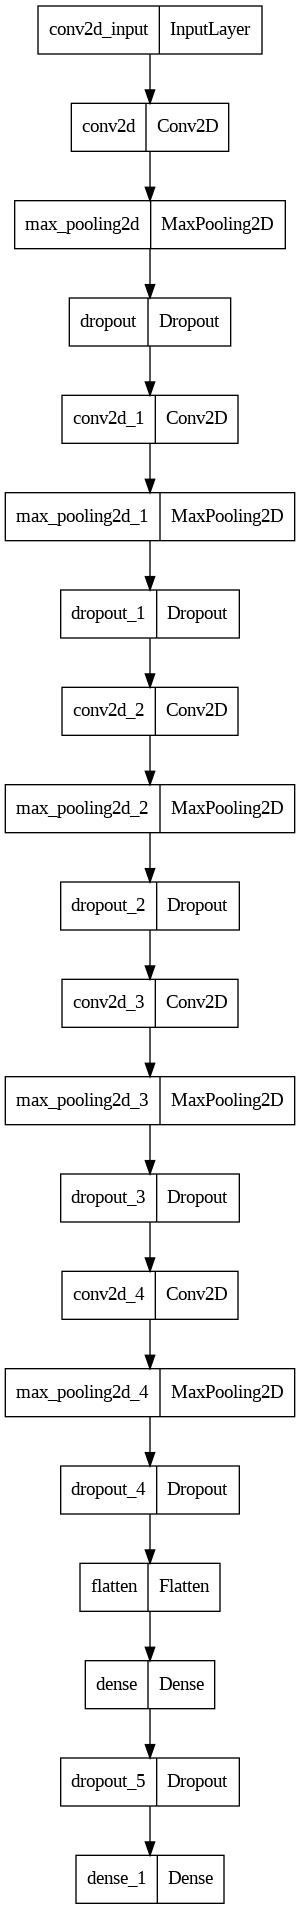

In [ ]:
model.summary() # Printing model summary
tf.keras.utils.plot_model(model) # Plotting model

# **VALIDATE🧾**

In [ ]:
# Loading best weights
model.load_weights('/content/no_fusion_weights.h5')

In [ ]:
preds = model.predict(inputs_test, batch_size=32)  # Running model on the test dataset
test_loss, test_acc = model.evaluate(inputs_test, targets_test) # Obtaining Loss and Accuracy on the test dataset

print('\nTest Loss: ', test_loss)
print('\nTest Accuracy: ', np.round(test_acc * 100), '%')

10/10 [==============================] - 0s 28ms/step - loss: 5.0936 - accuracy: 0.4108

Test Loss:  5.093576908111572

Test Accuracy:  41.0 %


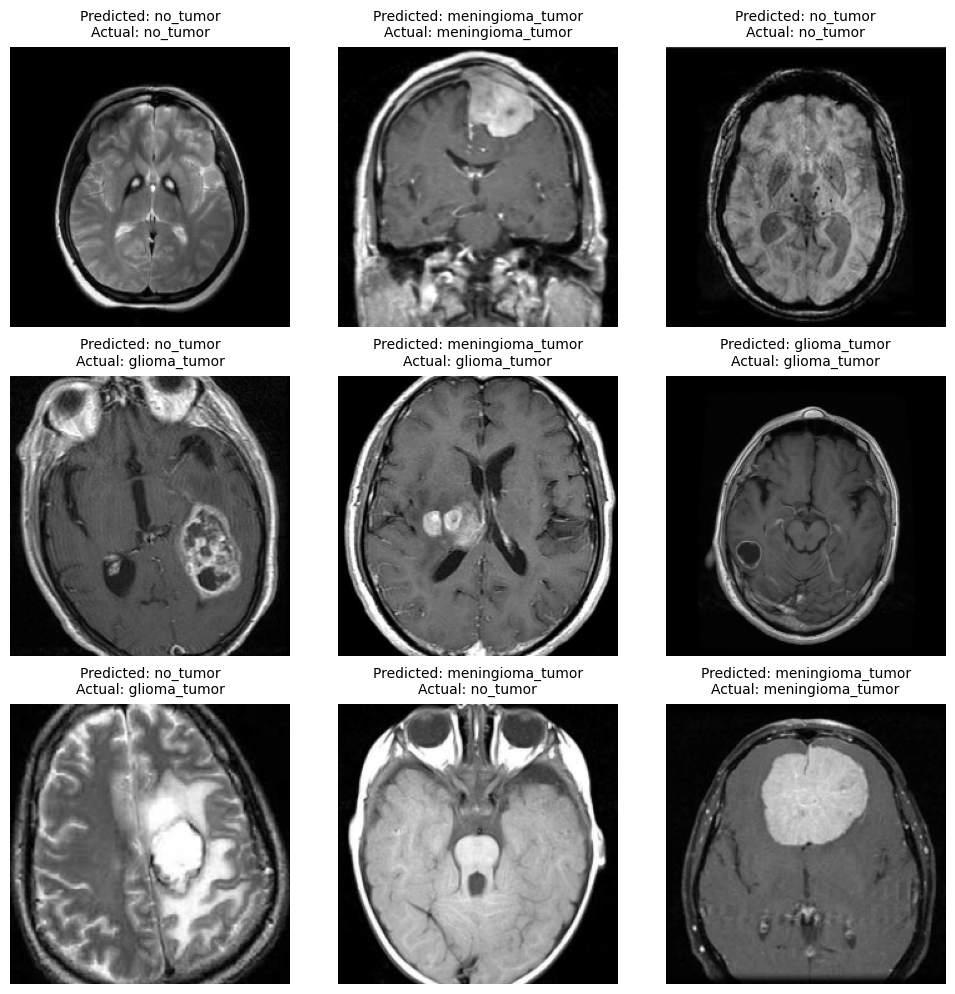

In [ ]:
y_pred_classes = np.argmax(preds, axis=1)
y_true_classes = np.argmax(targets_test, axis=1)
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Filtra le prime 9 immagini
num_images_to_display = 9
indices_to_display = np.random.choice(len(inputs_test), num_images_to_display, replace=False)

# Crea il grafico 3x3
plt.figure(figsize=(10, 10))
for i, index in enumerate(indices_to_display, 1):
    plt.subplot(3, 3, i)
    plt.imshow(inputs_test[index], cmap='gray')
    predicted_label = labels[y_pred_classes[index]]
    true_label = labels[y_true_classes[index]]
    plt.text(0.5, 1.08, f'Predicted: {predicted_label}\nActual: {true_label}',
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=plt.gca().transAxes)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Saving model
model.save('no_fusion_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

